In [1]:
import xarray as xr
import rioxarray
import geopandas as gpd
from landlab.grid import RasterModelGrid
from landlab.components import OverlandFlow
from landlab.components import CREST
import matplotlib.pyplot as plt


In [2]:
basin_shp= gpd.read_file('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/subbasins/08076700.shp',
                         crs='EPSG:4326')
# basin_shp= basin_shp.set_crs('EPSG:4326')
# basin_shp= basin_shp.to_crs('EPSG:32215')

In [3]:
dem_region= rioxarray.open_rasterio('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/Case study - Harvey/demHouston033s_NAm83.tif/demHouston033s_NAm83.tif')
dem_region= dem_region.rio.write_crs('EPSG:4326')
dem_region= dem_region.rio.reproject('EPSG:32215')

In [21]:
basin_dem= dem_region.rio.clip(basin_shp.geometry, basin_shp.crs)

In [ ]:
basin= RasterModelGrid(shape= basin_dem.shape, xy_spacing=)

In [26]:
?RasterModelGrid

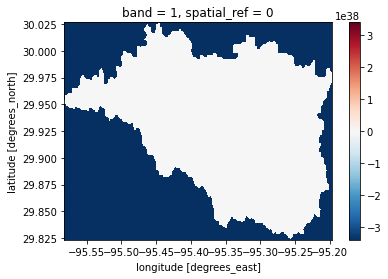

In [23]:
basin_dem.plot()